# Variational AutoEncoder
...

## Implementation
This implementation of VAE is trained on MNIST Dataset.

**Dimensions** 
- `b` : batch size
- `im` : flattened image size = 28*28 = 784
- `h` : latent vector size
### imports

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm import tqdm
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\PC\anaconda3\envs\diffuser\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preperation (Dataset, DataLoader)

In [3]:
train_data = MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)

trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128)

### Model
#### Encoder
input|<span style="font-weight:normal">flattened MNIST image `(torch.tensor: (b, im))`</span>
|:-------:|:---------------------------------------------------------------------------------|
**output**| mean, log-var `(Tuple[torch.tensor]: ((b, h), (b, h)))`

`Encoder` in feed-forward will get an input and outputs the mean and log-variance of the normal distribution of the latent variable.

- Reason for having log-variance($\log\sigma^2$) instead of variance($\sigma^2$) is because **variance should be non-negative**, and outputing log-variance and then applying exponential will naturally restrict the variace as non-negative. 
- Since we want features to be all independent, latent vector is considered to have have no covariance between dimensions. Therefore we only generate the diagonal term(variance) of the covariance matrix.

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        self.m = nn.Linear(hidden_size, latent_dim)
        self.lgvar = nn.Linear(hidden_size, latent_dim)
        
    def forward(self, x):
        x = self.fc(x)
        m, lgvar = self.m(x), self.lgvar(x)
        return m, lgvar

#### Decoder
input|<span style="font-weight:normal">Latent vector `(torch.tensor: (b, h))`</span>
|:-------:|:---------------------------------------------------------------------------------|
**output**| reconstructed image `(torch.tensor: (b, im))`

`Decoder` is a simply reconstructs the latent vector to the original input.

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x_hat = self.fc(x)
        return x_hat

#### VAE
input|<span style="font-weight:normal">flattened MNIST image `(torch.tensor: (b, im))`</span>
|:-------:|:---------------------------------------------------------------------------------------------------------------------|
**output**|(reconstructed image, (mean, log-var)) `(tuple)`<br />where<br /> -  reconstructed image `(torch.tensor: (b, im))`<br /> -  mean, log-var `(torch.tensor: (b, h))`

: `VAE` module wraps `Encoder` and `Decoder`. In feed-forward, `VAE` will sample latent variable from the $\mathcal{N}(\mu, \sigma^2)$ where $\mu$ and $\log{\sigma^2}$ is given by the `Encoder`. The sampled latent variable will the be fed to the `Decoder` to reconstruct the input.

- Since latent features are all assumed uncorrelated, we don't consider covariances and sample them independently.
- We use a technique of **Reparameterization** where we sample random noise $w\sim \mathcal{N}(0, 1)$ and reparameterize it as $w*\sigma+\mu$.
- In addition to reconstructed input, `VAE` outputs $\mu$ and $\log\sigma^2$ for use in the loss function.

In [6]:
class VAE(nn.Module):
    def __init__(self, data_size, hidden_size, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(data_size, hidden_size, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_size, data_size)
        
    def get_latent(self, x):
        m, lgvar = self.encoder(x)
        z = self.reparameterization(m, lgvar)
        return z
    
    def forward(self, x):
        m, lgvar = self.encoder(x)
        z = self.reparameterization(m, lgvar)
        x_hat = self.decoder(z)
        return x_hat, (m, lgvar)
    
    def reparameterization(self, m, lgvar):
        epsilon = torch.randn_like(lgvar).to(device)
        std = torch.exp(0.5*lgvar)
        z = m + std * epsilon
        return z

#### Declare model

In [7]:
model = VAE(28*28, 300, 2).to(device)

### Training
#### Loss function
Most part of training VAEs is similar to AutoEncoders. However the loss function has a additional **KL Divergence term**.
$$\mathbb{E}_{q_\phi(z|x)}[\log{p_\theta(\hat{x}|z)}]-D_{KL}(q_\phi(z|x)||p(z))$$
$$ = BCE(\hat{x}, x) - \frac{1}{2}(\sigma^2+m^2-\log\sigma^2-1)$$
- Normal `nn.BCELoss` or `F.binary_cross_entropy` will calculate mean over datas. In order for the code to work, we need to change keyword argument to `reduction='sum'` to sum over losses of datas.

In [14]:
def lossfn(x_hat, x, m, lgvar):
    reconstr_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KL_loss = torch.sum(torch.exp(lgvar) + m**2 - lgvar - 1)/2
    return reconstr_loss + KL_loss

#### Train setup

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

#### Training loop

In [35]:
losses = []
for epoch in range(epochs):
    ls = 0
    pbar = tqdm(trainloader)
    for x, _ in pbar:
        x = torch.flatten(x, 1).to(device)
        x_hat, (m, lgvar) = model(x)
        loss = lossfn(x_hat, x, m, lgvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ls+=loss.detach().cpu()
        pbar.set_description(f'epoch: {epoch+1}, loss: {loss.detach().cpu()/len(x):.5f}')
    losses.append(ls/len(train_data))

epoch: 10, loss: 138.44011: 100%|██████████| 469/469 [00:04<00:00, 106.45it/s]


#### Loss curve

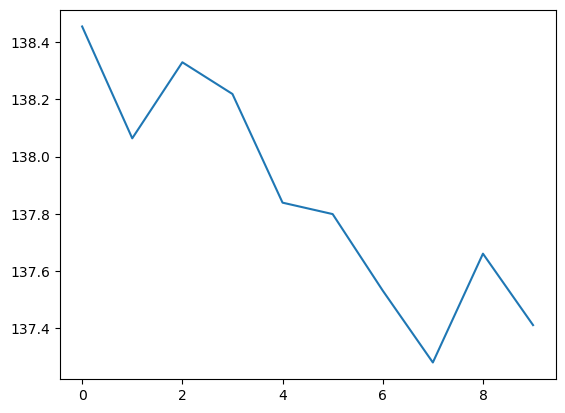

In [36]:
plt.plot(losses)

#### Plot latent vector distribution

100%|██████████| 79/79 [00:00<00:00, 96.08it/s] 


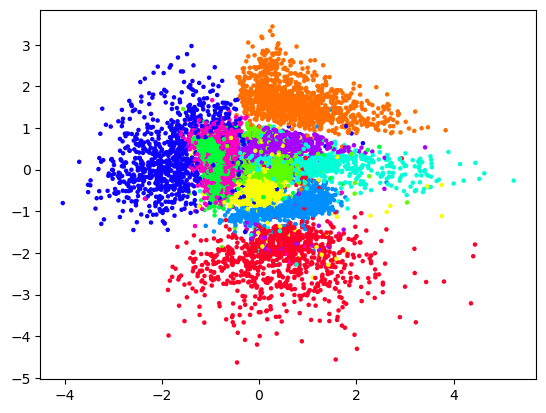

In [37]:
for x, t in tqdm(testloader):
    z = model.get_latent(torch.flatten(x, 1).to(device))[..., :2].detach().cpu()
    plt.scatter(*z.T, c=t, cmap='gist_rainbow', s=5)

#### Image Reconstruction

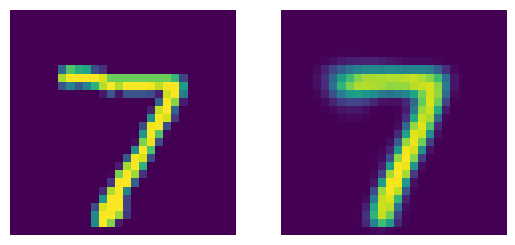

In [38]:
x, _ = test_data[0]
x_i = torch.flatten(x, 1).to(device)
x_hat = model(x_i)[0][0].detach().cpu()
x_hat = x_hat.view((28, 28))

plt.subplot(121), plt.axis('off')
plt.imshow(x[0])
plt.subplot(122), plt.axis('off')
plt.imshow(x_hat)